## Using the N-Body Method
Having written an n-body right hand side function and bound the gravitational acceleration, lets try it out! You'll need to assemble the right hand side code into a file that can be imported. Move the ODE code you wrote into the same directory or create a package. Then experiment with the following algorithm/initial conditions.

### Euler Richardson

Begin by resurrecting your ODE code and doing some runs with initial conditions provided below' `euler`, `montgomery`, and `lagrange`. We know our best algorithm will be Euler-Richardson.

#### Question:
Use Euler-Richardson integrate each of the initial conditions through 100 time units and plot the result. Adjust the time step to find a value where the orbit stable through the entire 100 unit interval. Note cases that can not be completed with stable orbits. Use the `time` module and function to determine the wall clock time required for the runs. Record the times and step requirements for future reference. Also, make an accounting of how many calls to the `n-body` function occur.

**Note:** I've tried to save you the hassle of writing plotting code. Writing this is tedious at best. The problem is, I don't think mine is especially tidy. If you feel like replacing mine with something better, by all means, go for it.

**Observation:** To ensure stability of orbits, these runs are requiring tens of seconds to minutes to make. Are we really condemned to such terrible performance?


## Better ODE Solutions: Runge Kutta 4

The simplest to implement, but steadiest performance for ODE integration can be realized with the *fourth order Runge-Kutta* methods. If you are in a situation where you have to implement the algorithm yourself, this provides the greatest return on your time. It also shows the way forward, which is weighted averages of slopes evaluated throughout the interval. The following equations have errors of order $\mathcal{O}(\Delta t^5)$, meaning the log of error vs log of time step plot sees error decrease with a slope of five. That's fast!

Here are the equations:

$$
\begin{align}
k_1 &=& &h f(x_n,y_n)\\
k_2 &=& &h f(x_n + \frac{1}{2}h,y_n + \frac{1}{2} k_1)\\
k_3 &=& &h f(x_n + \frac{1}{2}h,y_n + \frac{1}{2} k_2)\\
k_4 &=& &h f(x_n + h,y_n +  k_3)
\end{align}
$$

$$y_{n+1} = y_n + \frac{1}{6} k_1 + \frac{1}{3} k_2 + \frac{1}{3} k_3 + \frac{1}{6} k_4 $$

Where I've broken with previous convention to generalize ($t_n \rightarrow x_n$) and simplify ($\Delta t \rightarrow h$).

Add an implementation of these methods to your ODE code.

#### Question:
Use Runge-Kutta 4 to integrate each of the initial conditions through 100 time units and plot the result. Adjust the time and find a point where the orbit stable through the entire time interval. Note cases that can not be completed without instabilities. Use the `time` module and function to determine the time required. Record the times and time step requirements for future reference. Also, make an accounting of how many function calls occur.

### Runge Kutta 45

A major part of this assignment will be reading and implementing an algorithm that is outlined on the [numerical recipes web site](http://numerical.recipes/book/book.html). Numerical Recipes is a classic text for scientific computing methods. Not only are the methods well explained, the commentary is extremely insightful.

In short, this algorithm will take the difference between 4th and a 5th order accurate estimates of $y_{n+1}$ and use that difference as an error estimate. The error estimate in turn, is used to control step size. The equations for the 5th order accurate estimate look like the following:

$$
\begin{align}
k_1 &= hf(x_n,y_n)\\
k_2 &= hf(x_n + c_2 h, y_n + a_{21}k_1)\\
&\cdots\\
k_6 &=  hf(x_n + c_6 h, y_n + a_{61}k_1+\cdots+ a_{65}k_5)\\
y_{n+1} &= y_n + b_1 k_1 + b_2 k_2 + b_3 k_3 + b_4 k_4 + b_5 k_5 + b_6 k_6 +\mathcal{O}(h^6)&
\end{align}
$$

Now, here is the remarkable feature of this algorithm: *the 4th order accurate estimate can be found using the same $k$ values, but different $b$ values.* The following formula makes that clear by writing the 4th order accurate solution as $y_{n+1}^*$:


$$
y^*_{n+1} = y_n + b^*_1 k_1 + b^*_2 k_2 + b^*_3 k_3 + b^*_4 k_4 + b^*_5 k_5 + b^*_6 k_6 +\mathcal{O}(h^5)
$$

Hence, the errors are
$$
\Delta = y_{n+1} - y^*_{n+1} = \sum_{i=1}^6 (b_i - b_i^*)k_i
$$

The particular values for the constants were found by Dormand and Prince.

![](rk45_coefficients.png)

Additional implementation details are found in the Numerical Recipes reference.


### Questions
After successful implementation of the RK45 algorithm, answer the following question.

1. Make a complete run (100 time units) for each of the initial conditions provided below. Determine the `abs` and `rtol` values needed to get stable orbits on this time scale. Note cases that can not be completed without instabilities. Use the `time` module and function to determine the time required. Record the times and time step requirements for future reference. Create a table that has each of the three algorithms (`EulerRichardson`, `RK4`, `RK45`) as rows, and in the columns record the maximum `dt` or `atol` and`rtol`, the number of function calls, and the time required for execution. Write a brief statement about which of the algorithms you believe is best, and why.
2. For fun, complete all the initial conditions at the end of the page and include plots of their orbits.
3. Examine the stability of the solutions to the three-body problem (`euler`,`mongomery`,`lagrange`,`skinny_pineapple`, `hand_in_oval`) by slightly varying the initial velocity of one of the masses by ~0.5%. Before passing your new initial state to the ODE solver, calculate the center of mass velocity and subtract this velocity from every object. Based on what you see, determine if the instability an inherit physical property, or the result of the ODE solver? Make a clear statement about which initial conditions are stable or unstable. Compute and monitor the conservation of the total energy (that is potential plus kinetic). Total energy can be computed from the ODE output and plotted.

Potential energy is

$$V_{ij} = -\frac{G m_i m_j}{r_{ij}}$$
where unlike force, potential energy *only counts once for each pair*. This would amount to the entries in the upper triangle of a $V$ matrix. Indeed, I think the way to compute this is with nested loops, quite similar to what was done for our forces in the n-body calculation.

Kinetic energy is

$$KE_i = \frac{1}{2} m_i v_i^2$$

for each body $i$.

The sum $KE +V$ for all particles is the total energy of the system. This should remain a constant through the simulation.

**Note on calculation:** Compute the potential, kinetic, and total energy from the final array of state vectors that are given back by the ODE solver.

In [1]:
import time
from sim import *

y0 = euler
p  = p3
dt = 0.01
t_span = [0,10]
d=2

start_t = time.time()
t_s,y = solve_ode(n_body,t_span, y0, RungeKutta4, p,first_step=dt)

end_t = time.time()
print("Elapsed time = %4.3f seconds."%(end_t-start_t))


anim = show_anim(t_s,y,dt,y0)
plt.close()
display(HTML(anim.to_html5_video()))

(-3.7200009065413053, -3.7199995809146333)

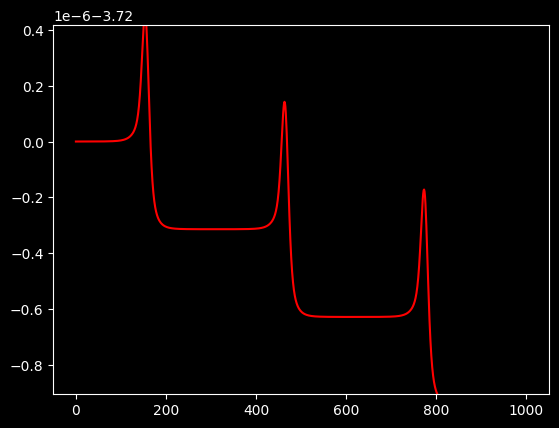

In [2]:
plt.axis("on")
E = total_energy(y,p)
plt.plot(E,'r')
small = 1e-8
plt.ylim(E.min()*(1-small),E.max()*(1+small))

In [3]:
y0 = montgomery
p  = p3
dt = .05
t_span = [0,100]
d=2

start_t = time.time()
t_s,y = solve_ode(n_body,t_span, y0, RK4, p,atol=1e-10,rtol=1e-14,first_step=dt)
end_t = time.time()
print("Time Elapsed = %4.3f seconds."%(end_t-start_t))
anim = show_anim(t_s,y)
HTML(anim.to_html5_video())
plt.style.use("seaborn-v0_8")
plt.axis("on")
E = total_energy(y,p)
#plt.plot(E,'r')
small = 1e-7
#plt.ylim(E.min()*(1-small),E.max()*(1+small))

NameError: name 'RK4' is not defined

In [ ]:
y0 = lagrange
p  = p3
dt = .05
t_span = [0,100]
d=2

start_t = time.time()
t_s,y = solve_ode(n_body,t_span, y0, RK45, p,first_step=dt,\
                 rtol = 1e-10,atol=1e-14)
end_t = time.time()
print("Time Elapsed = %4.3f seconds."%(end_t-start_t))
anim = show_anim(t_s,y)

HTML(anim.to_html5_video())


In [ ]:
plt.style.use('seaborn')
plt.axis("on")
E = total_energy(y,p)
plt.plot(E,'r')
small = 1e-8
plt.ylim(E.min()*(1-small),E.max()*(1+small))

In [ ]:
# More initial conditions to experiment with:

skinny_pinapple = array([0.419698802831,1.190466261252,\
                        0.076399621771,  0.296331688995,\
                        0.100310663856, -0.729358656127,\
                        0.102294566003,  0.687248445943,\
                        0.148950262064,  0.240179781043,\
                       -0.251244828060, -0.927428226977])

hand_in_hand_oval = array([0.906009977921, 0.347143444587,\
                          -0.263245299491, 0.140120037700,\
                          -0.252150695248, -0.661320078799,\
                           0.242474965162, 1.045019736387,\
                          -0.360704684300, -0.807167979922,\
                           0.118229719138, -0.237851756465])

four_body = array([1.382857,0,\
                   0,0.157030,\
                  -1.382857,0,\
                   0,-0.157030,\
                   0,0.584873,\
                   1.871935,0,\
                   0,-0.584873,\
                  -1.871935,0])

helium_1 = array([0,0,2,0,-1,0,0,0,0,.95,0,-1])s
helium_2 = array([0,0,3,0,1,0,0,0,0,.4,0,-1])

# You'll have to tailor some of the parameters to the simulation - something like the following

p4 = {'m':array([1,1,1,1]),'G':1,'dimension':2,'force':gravitational,'fix_first':False}
p3 = {'m':array([1,1,1]),'G':1,'dimension':2,'force':gravitational,'fix_first':False}
p_he = {'m':array([2,-1,-1]),'G':1,'dimension':2,'force':gravitational,'fix_first':True}


### Bounties
* Show an implementation of RK4
* Show a method of counting function calls.
* Reconcile time step with adaptive time stepping.
* Show how FSAL works
* Define the estimation of errors in RK45.
* Define the adaptive step size in RK45.
* Walk through the looping in a function to determine the total energy.